### Resources

- https://github.com/danielTeniente/curso-IA
- https://www.youtube.com/watch?v=MN96NzKzF0Q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
from scipy.stats import uniform
from PIL import Image

def draw_egde(a, b, hw=0.0, color="green"):
    # Connect points a and b with an arrow -->
    plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1],
    head_width=hw, length_includes_head=True, color=color
    )

def make_ring(N, K):
    # N: nodes, K: degree, avg connections per node
    # N: nodes 
    # K: neighbors, K//2 at left, K//2 at right

    # Make ring connectivity
    adj_list = []
    for ni in range(N):
        adj_list += [[]]
        for ki in range(1,K//2+1):
            adj_list[ni] += [ni-ki, ni+ki]

    adj_list = np.array([np.array(ai) for ai in adj_list])

    # Correct borders to create closed condtion
    pos = np.where(adj_list<0)
    adj_list[pos] = adj_list[pos] + N
    pos = np.where(adj_list>=N)
    adj_list[pos] = adj_list[pos] - N

    return adj_list

def plot_circular_layout(adj_list, hw=0.0, rewired_arcs=None):
    t = np.linspace(0, 2*np.pi, N, endpoint=False)  # angle in radians
    # Convert from polar to cartesian 
    x = np.cos(t)
    y = np.sin(t)

    plt.figure(figsize=(8,8))
    plt.plot(x, y, '.', ms=30)
    #a = plt.xlim(-0.1, 2.1)
    #a = plt.ylim(-0.1, 2.1)
    a = plt.axis('off')
    for i in range(N):
        plt.text(x[i]-0.015, y[i]-0.015, i, weight='bold', c='w')
    # a: node of origin, b: destination node. a --> b
    e = [draw_egde([x[a], y[a]], [x[b], y[b]], hw) for a in adj_list for b in adj_list[a]]

    if rewired_arcs is not None:
        e = [draw_egde([x[a], y[a]], [x[b], y[b]], hw, 'red') 
            for a in rewired_arcs for b in rewired_arcs[a]]

def rewire_ring(C, omega):
    # C: adjacecy list, omega: K_r / K, fraction of random shortcuts
    # loop over nodes
    all_nodes = set(range(len(C)))
    for i, ci in enumerate(C):
        # loop over neighborhood
        for j, cj in enumerate(ci):
            # rewire if U(0,1) < omega
            if np.random.random() < omega:
                available_nodes = list(all_nodes - (set([i] + list(ci)) - set([cj])))
                C[i, j] = np.random.choice(available_nodes)

def make_random(N, K):
    # erdos renyi model
    C = []
    for i in range(N):
        C += np.where(np.insert(bernoulli.rvs(K/N, size=(N-1)), i, 0))
    return np.array(C, dtype='object')

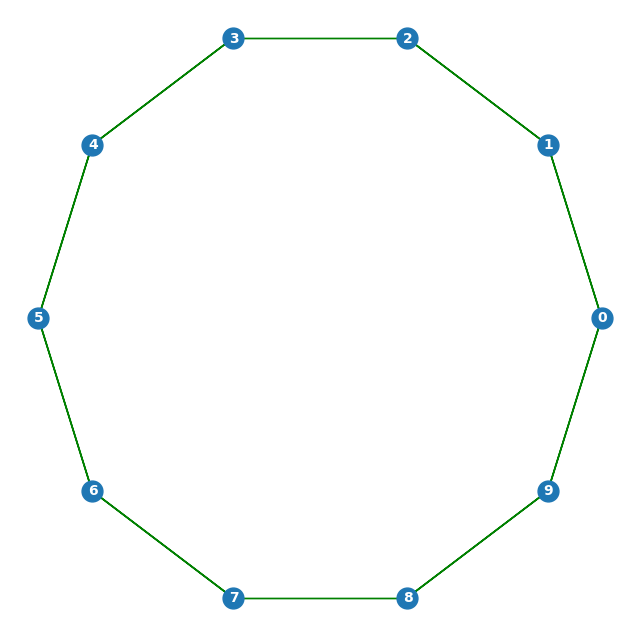

In [ ]:
N = 10
K = 2

C = make_ring(N, K)

adj_list = {ni: C[ni] for ni in range(N)}

plot_circular_layout(adj_list)

### ANN

0. Generate/read/load a set of **binary patterns set X**, P patterns of size N
1. Generate network structure, connectivity C, and W=0.
  - N: nodes (input size)
  - K: average connectivity per node
  - C: Network topology (Ring, Random, small-world)
2. **Learning stage:** Learn the pattern set (Hebbian learning)
    - $W_{ij}^0 = 0$
    - For pi in P (patterns):
      - Update Wij += Wij. Commulative.
3. **Retrieval stage**
  3.1 Start network in a learned pattern o close to it **(input stimulus)**. 
  - Noise (pattern denoising)
  - Fragment (pattern completion)
  3.2 Evolve the network (for a given steps) to a final state
  3.3 Check the quality of retrieval (measure the similarity or overlap between net state and intended pattern)

4. **Unbiased case**
  - $P(X_i^\mu = 1) = a, i \in \{1, N\}; \mu \in \{1, P\}$, $a$ is the pattern activity (average of the pattern).
    - For the unbiased case we have $a=0.5$.
  - What is the distribution of $X$?
    - $X \sim Bern(p=a)$.

  - We have already standardized: $Z = \frac{X - \mu}{\sigma}$ 
  - For Bernoulli we have $\mu = p$, and variance $\sigma^2 = p \cdot (1-p)$.
  - For p = 0.5: 
  $$\frac{X - 0.5}{\sqrt{0.25}} = (X - 1/2) / (1/2) = 2\cdot X - 1$$

5. **Biased case**
- Normalize the patterns
- Dynamic **retrieval neural threshold** to keep the **activity** of the network
  - $\Theta(h - \theta)$, $h$ is the normalized neural input, $\theta$ is the **neural threshold**.

In [ ]:
# Generate random patterns
activity = 0.5  # P(X=1)
P = 10
p_size = 10  # pattern size: number of nodes in the network
# X: pattern set
X = bernoulli.rvs(p=0.5, size=(P, p_size))*2-1
X

array([[ 1, -1,  1,  1, -1, -1, -1,  1, -1,  1],
       [-1, -1, -1, -1,  1,  1, -1,  1,  1, -1],
       [-1,  1,  1,  1, -1, -1, -1,  1, -1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1, -1,  1],
       [ 1, -1,  1, -1, -1, -1, -1,  1, -1, -1],
       [ 1,  1, -1, -1, -1, -1,  1,  1,  1,  1],
       [-1,  1, -1, -1, -1, -1,  1, -1,  1,  1],
       [ 1,  1, -1, -1, -1,  1, -1, -1,  1, -1],
       [-1,  1, -1, -1, -1, -1,  1,  1,  1,  1],
       [ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1]])

In [ ]:
C

array([[9, 1],
       [0, 2],
       [1, 3],
       [2, 4],
       [3, 5],
       [4, 6],
       [5, 7],
       [6, 8],
       [7, 9],
       [8, 0]])

In [ ]:
# This the pattern, and we will make it equal to
# the net state sigma
# xi is pattern 0
xi = X[0]
# This is node 0
ni = 1
xi, {ni: C[ni]}, xi[C[ni]], xi[ni], xi[C[ni]] * xi[ni]

(array([ 1, -1,  1,  1, -1, -1, -1,  1, -1,  1]),
 {1: array([0, 2])},
 array([1, 1]),
 -1,
 array([-1, -1]))

In [ ]:
# Init W as 0
W = [np.zeros(len(C[ni])) for ni in range(N)]
# update weights for each pattern
for xi in X:
    # update connectivity weight of each node
    for ni in range(N):
        W[ni] += xi[C[ni]] * xi[ni]

W

[array([ 2., -4.]),
 array([-4., -4.]),
 array([-4.,  6.]),
 array([6., 2.]),
 array([2., 4.]),
 array([ 4., -2.]),
 array([-2., -4.]),
 array([-4., -2.]),
 array([-2.,  2.]),
 array([2., 2.])]

In [ ]:
# We present pattern 0 as initial state
xi = X[0]

# Update states of each node
# node 0
ni = 0
# Activation function (threshold, heavyside step function)
(xi[C[ni]] * W[ni]).sum() >= 0

True

In [ ]:
# Measure quality of retrieval (overlap similarity)
xi = X[0]
(-xi*xi).sum()/N

-1.0

(0.0, 1.0)

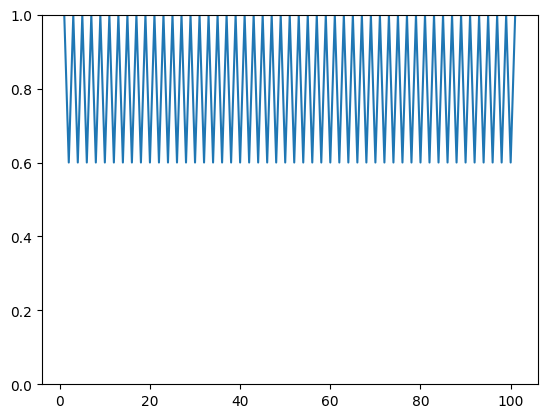

In [ ]:
time = 100
xi = X[9]  # Test pattern
# measure overlap

states = xi.copy()
# measure overlap between net and intended pattern 0
m = [(xi*states).sum()/N]
for i in range(time):
    # Update all nodes
    states = np.array([(states[C[ni]] * W[ni]).sum() >= 0 for ni in range(N)])*2-1
    m += [(xi*states).sum()/N]

plt.plot(range(1,102), np.abs(m))
plt.ylim(0, 1)

In [ ]:
m[:10]

[1.0, 0.4, 0.4, 0.2, 0.4, 0.2, 0.4, 0.2, 0.4, 0.2]

(0.0, 1.1)

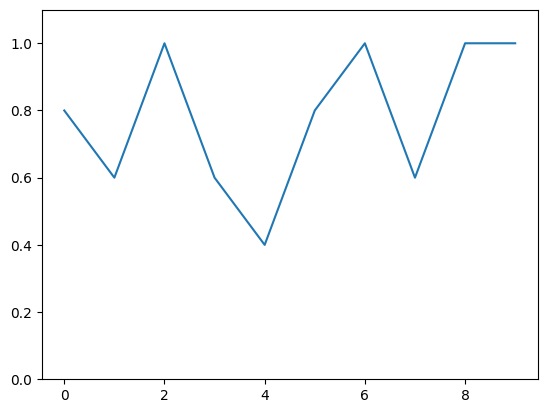

In [ ]:
P = 10
time = 100
# measure overlap

M = []

for pi in range(P):
    # measure overlap between net and intended pattern ni
    xi = X[pi]
    states = xi.copy()
    m = [(xi*states).sum()/N]
    for i in range(time):
        # Update all nodes
        states = np.array([(states[C[ni]] * W[ni]).sum() >= 0 for ni in range(N)])*2-1
        m += [(xi*states).sum()/N]
        if m[-1] == m[-2]:
            break
    M += [m[-1]]

M = np.array(M)
plt.plot(abs(M))
plt.ylim(0,1.1)

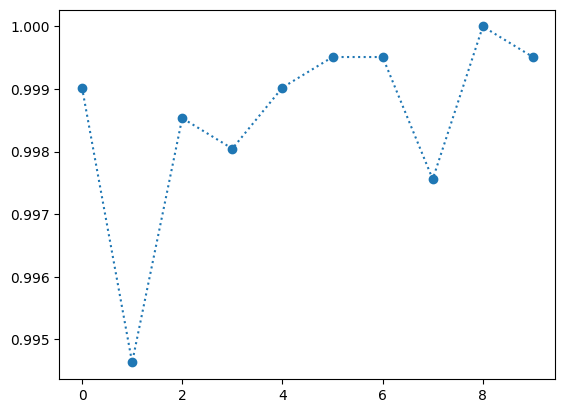

In [ ]:
N = 64*64  # size of the pattern/network nodes
K = 100  # avg connectivity per node (network degree)

C = make_ring(N, K)

# Generate random patterns
activity = 0.5  # P(X=1)
P = 10
p_size = N  # pattern size: number of nodes in the network
# X: pattern set
X = bernoulli.rvs(p=0.5, size=(P, p_size))*2-1

# Init W as 0
W = [np.zeros(len(C[ni])) for ni in range(N)]
# update weights for each pattern
for xi in X:
    # update connectivity list of each node
    for ni in range(N):
        W[ni] += xi[C[ni]] * xi[ni]

time = 100
# measure overlap

M = []

for pi in range(P):
    # measure overlap between net and intended pattern ni
    xi = X[pi]
    states = xi.copy()
    m = [(xi*states).sum()/N]
    for i in range(time):
        # Update all nodes
        states = np.array([(states[C[ni]] * W[ni]).sum() >= 0 for ni in range(N)])*2-1
        m += [(xi*states).sum()/N]
        if m[-1] == m[-2]:
            break
    M += [m[-1]]

M = np.array(M)
plt.plot(abs(M), ':o')
#plt.ylim(0, 1.1)

In [ ]:
!wget https://raw.githubusercontent.com/marsgr6/r-scripts/master/notebooks/ai/lenna.png

--2023-04-20 00:40:03--  https://raw.githubusercontent.com/marsgr6/r-scripts/master/notebooks/ai/lenna.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lenna.png.2’

lenna.png.2         100%[===================>] 462.73K  --.-KB/s    in 0.004s  

2023-04-20 00:40:04 (103 MB/s) - ‘lenna.png.2’ saved [473831/473831]



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


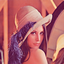

In [ ]:
from PIL import Image

img = Image.open('./lenna.png')
img = img.resize((64,64), Image.ANTIALIAS)
img

26 240


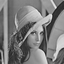

In [ ]:
imggs = img.convert('L')
print(np.array(imggs).min(), np.array(imggs).max())
imggs

In [ ]:
# gray threshold binarization
imbn = (np.array(imggs) > 128)*1
imbn, imbn.mean()

(array([[1, 1, 1, ..., 0, 0, 1],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]),
 0.488037109375)

activity: 0.488037109375


(-0.5, 63.5, 63.5, -0.5)

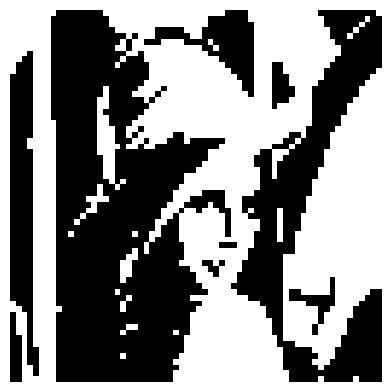

In [ ]:
th_value = 128
imgbw = np.asarray(imggs)
imgbw = (imgbw > th_value)*1
imgbw = 1 - imgbw
plt.matshow(imgbw, cmap='Greys')
print('activity:', 1 - np.mean(imgbw))
lenna = imgbw.reshape(1, 64*64)*2-1
plt.axis('off')

(10, 4096)


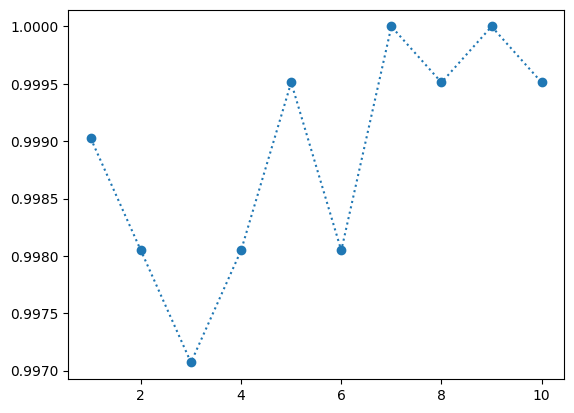

In [ ]:
N = 64*64
K = 100
P = 10
# Learn P-1 pattern, 10th pattern is the image
X = np.random.randint(2, size=(P-1, N))*2-1
X = np.concatenate((X, lenna))  # this is the image
print(np.shape(X))

# Generate network structure
C = make_ring(N, K)
# Start W=0
W = np.array([np.zeros(len(C[ni])) for ni in range(N)])
# Hebb learning
for xi in X:
    for ni in range(N):
        W[ni] += xi[C[ni]]*xi[ni]

time = 100
# M: final overlap for each pattern
# store m_i in M for each pattern
M = []
for xi in X:
    states = xi.copy()
    #update network
    m = [(states*xi).mean()]
    for ti in range(time):
        # update all neurons
        states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
        m += [(states*xi).mean()]
        if m[-2] == m[-1]:
            break
    M += [m[-1]]
plt.plot(range(1, P+1), np.abs(M), ':o')
#plt.ylim(0,1.1)

((array([0]), array([1044])), 16, 20)

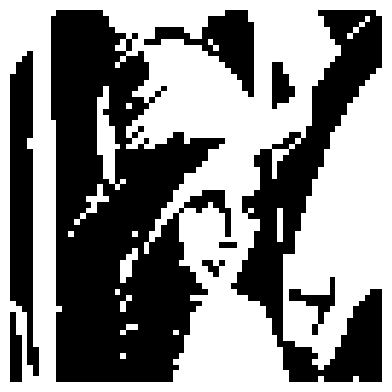

In [ ]:
plt.matshow(states.reshape(64,64), cmap='Greys')
plt.axis('off')
np.where(states != lenna), 1044//64,  1044%64

array([[-1, -1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1, -1,  1],
       [ 1, -1,  1, ..., -1,  1,  1],
       ...,
       [ 1,  1, -1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1, -1, ...,  1, -1,  1]])

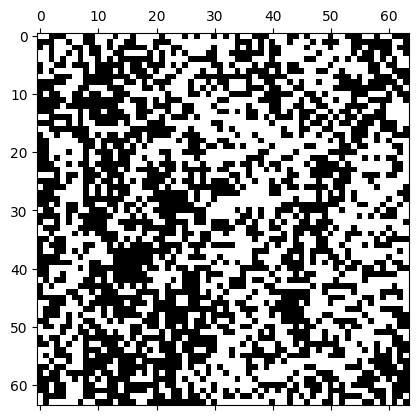

In [ ]:
noise_level = 0.7

noisy_lenna = lenna.copy()

for i in range(np.shape(noisy_lenna)[1]):
    if np.random.random() < noise_level:
        noisy_lenna[0, i] = np.random.randint(2)*2 - 1

plt.matshow(noisy_lenna.reshape((64,64)), cmap='Greys')

noisy_lenna.reshape((64,64))

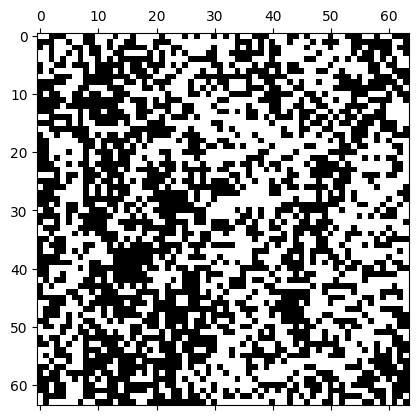

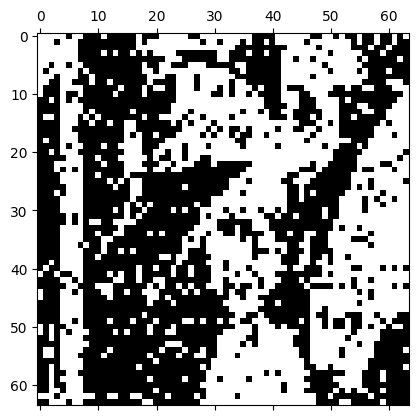

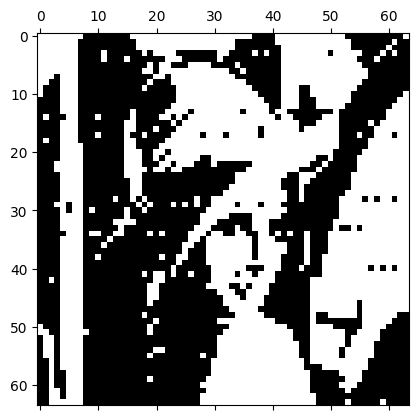

In [ ]:
states = noisy_lenna.flatten()
#update network
m = [(states*X[-1]).mean()]

plt.matshow(states.reshape((64,64)), cmap='Greys')

time = 100
for ti in range(time):
    # update all neurons
    states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
    if not (ti % 50):
        plt.matshow(states.reshape((64,64)), cmap='Greys')
    m += [(states*X[-1]).mean()]

([<matplotlib.lines.Line2D at 0x7fd48d84d090>], 0.9638671875)

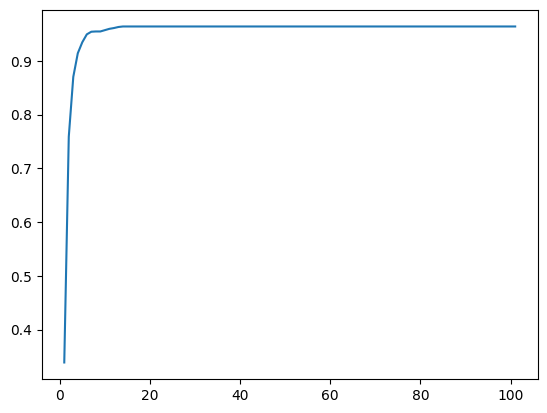

In [ ]:
plt.plot(range(1, len(m)+1), m), m[-1]

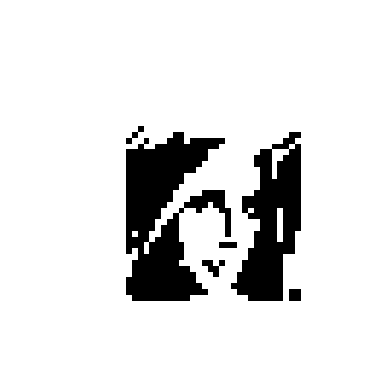

In [ ]:
lenna_rostro = np.zeros((64,64), dtype='int')

lenna_rostro[20:50,20:50] = imgbw[20:50,20:50]

plt.matshow(lenna_rostro, cmap='Greys')
a = plt.axis('off')

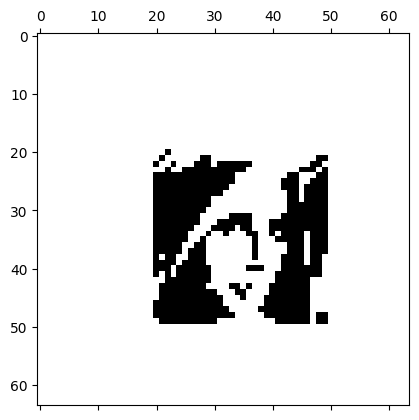

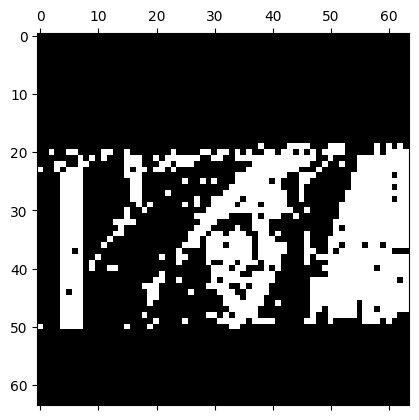

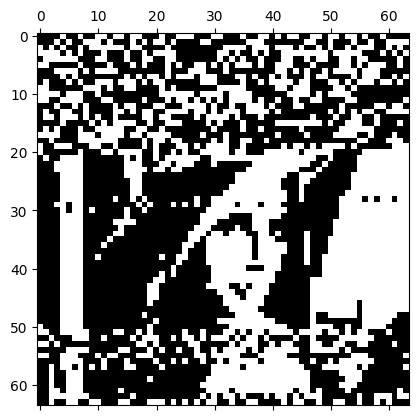

In [ ]:
states = lenna_rostro.flatten()
#update network
m = [(states*X[-1]).mean()]

plt.matshow(states.reshape((64,64)), cmap='Greys')

time = 100
for ti in range(time):
    # update all neurons
    states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
    if not (ti % 50):
        plt.matshow(states.reshape((64,64)), cmap='Greys')
    m += [(states*X[-1]).mean()]

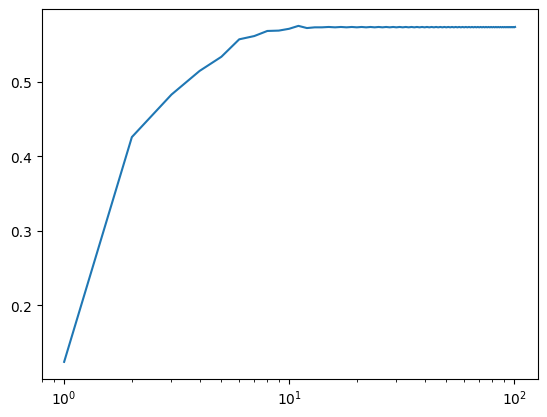

In [ ]:
plt.semilogx(range(1, len(m)+1), m)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cce3455d-da08-4c10-a6fe-39f2a30c6a51' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>